## Redes Neurais Artificiais 2020.1

**Disciplina**: Redes Neurais Artificiais 2020.1  
**Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)<br/>
**Github**: http://github.com/elloa  
**Dupla**:
  - Dayvson dos Santos Silva<br/>
    **Email**: ddss.snf19@uea.edu.br<br/>
    **GitHub**: https://github.com/userddssilva<br/>
  - Hiago Oliveira de Jesus<br/>
    **Email**: hodj.lic@uea.edu.br<br/>
    **GitHub**: https://github.com/HiagoOliver<br/>        

Levando em conta a base de dados **_Forest Cover Type_**, esta terceira parte do Projeto Prático 3 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Testando Redes Neurais sem os Atributos Categórios

1. Abra a base de dados em questão
2. Elimine todas as colunas relativas aos atributos categóricos
3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X
4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória
5. Efetue o escalonamento dos atributos


### Escalonando os atributos

O treinamento de uma rede neural artificial é mais eficiente quando os valores que lhes são fornecidos como entrada são pequenos, pois isto favorece a convergência. Isto é feito escalonando-se todos os atributos para o intervalo [0,1], mas precisa ser feito de maneira cautelosa, para que informações do conjunto de teste não sejam fornecidas no treinamento.

Há duas estratégias para tal escalonamento: normalização e padronização. Ambas possuem características particulares, vantagens e limitações, como é possível ver aqui: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


No nosso caso, vamos usar a padronização. Assim, com os atributos preditores do treinamento, isto é, X_train, deve-se subtrair a média e dividir pelo desvio padrão:

X_train_std = (X_train - np.mean(X_train))/np.std(X_train)

Em seguida, o mesmo deve ser feito com os atributos preditores do conjunto de testes, mas com padronização relativa ao conjunto de treinamento:

X_test_std = (X_test - np.mean(X_train))/np.std(X_train)

Se todo o conjunto X for utilizado na padronização, a rede neural receberá informações do conjunto de teste por meio da média e variância utilizada para preparar os dados de treinamento, o que não é desejável.

### Continuando

6. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios  
    6.1 Utilize a função de ativação ReLU  
    6.2 Utilize o solver Adam    
    6.3 Imprima o passo a passo do treinamento    
    6.4 Utilize o número máximo de épocas igual a 300  
7. Com o modelo em questão, após o treinamento, apresente:  
    7.1 Matriz de confusão para o conjunto de teste  
    7.2 Acurácia  
    7.3 F-Score  
    7.4 Precisão  
    7.5 Revocação  
8. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 100 vezes  
    8.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
    8.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
9. Repita por 100 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  
    9.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
10. Houve influência da escolha do otimizador no desempenho da rede?

### Importando as bibliotecas

In [30]:
import re
import warnings
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prettytable import PrettyTable

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

## Testando Redes Neurais sem os Atributos Categórios


### 1. Abra a base de dados em questão




- Leitura da base de dados

In [2]:
database = pd.read_csv('../database/covtype.csv')
database

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


### 2. Elimine todas as colunas relativas aos atributos categóricos


- Colunas da base de dados anterior a eliminação dos atributos categóricos

In [3]:
database.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

- Os nomes das colunas que representam valores categóricos possuem como substring "Wilderness_Area" ou "Soil_Type". As expressões regulares foram utilizadas para seleção das colunas a serem eliminadas.  


In [4]:
columns_to_drop = []
for column in list(database.columns):
    column_search = re.search('Soil_Type|Wilderness_Area', column)
    if column_search:
        columns_to_drop.append(column)
database.drop(columns=columns_to_drop, axis=1, inplace=True)   

- Colunas da base de dados posterior a eliminação dos atributos categóricos

In [5]:
database.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Cover_Type'],
      dtype='object')

### 3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X


- Alocando o atributo alvo na variável y

In [6]:
y = database.Cover_Type
y

0         5
1         5
2         2
3         2
4         5
         ..
581007    3
581008    3
581009    3
581010    3
581011    3
Name: Cover_Type, Length: 581012, dtype: int64

- Alocando os atributos preditores na variável X

In [7]:
X = database.iloc[:, :-1]
X

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,2596,51,3,258,0,510,221,232,148,6279
1,2590,56,2,212,-6,390,220,235,151,6225
2,2804,139,9,268,65,3180,234,238,135,6121
3,2785,155,18,242,118,3090,238,238,122,6211
4,2595,45,2,153,-1,391,220,234,150,6172
...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837
581008,2391,152,19,67,12,95,240,237,119,845
581009,2386,159,17,60,7,90,236,241,130,854
581010,2384,170,15,60,5,90,230,245,143,864


### 4. Efetue uma partição holdout 70/30 com o Sklearn, distribuindo os exemplos de maneira aleatória

- Particionando a base de dados em 70% para treinamento e 30% para teste

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

- A base de dados contém 581012 instâncias, das quais 406708 instâncias representam 70% dos dados e 174304 instâncias caracterizam 30% dos dados.

In [9]:
X_train.shape, X_test.shape

((406708, 10), (174304, 10))

### 5. Efetue o escalonamento dos atributos

- Escalonando os atributos preditores do conjunto treinamento e teste

In [10]:
# escalonando os dados
X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

### 6. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios 



```
6.1 Utilize a função de ativação ReLU
6.2 Utilize o solver Adam
6.3 Imprima o passo a passo do treinamento    
6.4 Utilize o número máximo de épocas igual a 300 
6.3 Imprima o passo a passo do treinamento
```

In [11]:
net_classifier_1 = MLPClassifier(hidden_layer_sizes=(10,), 
                                    activation='relu', 
                                    solver='adam', 
                                    verbose=True, 
                                    max_iter=300)
net_classifier_1.fit(X_train_std, y_train)

Iteration 1, loss = 0.90109021
Iteration 2, loss = 0.70470411
Iteration 3, loss = 0.68760747
Iteration 4, loss = 0.68087439
Iteration 5, loss = 0.67701429
Iteration 6, loss = 0.67406178
Iteration 7, loss = 0.67070411
Iteration 8, loss = 0.66736452
Iteration 9, loss = 0.66465546
Iteration 10, loss = 0.66251030
Iteration 11, loss = 0.66096957
Iteration 12, loss = 0.65988251
Iteration 13, loss = 0.65910406
Iteration 14, loss = 0.65856302
Iteration 15, loss = 0.65792580
Iteration 16, loss = 0.65740559
Iteration 17, loss = 0.65683863
Iteration 18, loss = 0.65632667
Iteration 19, loss = 0.65575770
Iteration 20, loss = 0.65512580
Iteration 21, loss = 0.65434646
Iteration 22, loss = 0.65354208
Iteration 23, loss = 0.65279618
Iteration 24, loss = 0.65229457
Iteration 25, loss = 0.65187873
Iteration 26, loss = 0.65153324
Iteration 27, loss = 0.65122289
Iteration 28, loss = 0.65099163
Iteration 29, loss = 0.65065567
Iteration 30, loss = 0.65042559
Iteration 31, loss = 0.65035136
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(10,), max_iter=300, verbose=True)

### 7. Com o modelo em questão, após o treinamento, apresente:
```
7.1 Matriz de confusão para o conjunto de teste  
7.2 Acurácia  
7.3 F-Score  
7.4 Precisão  
7.5 Revocação 
```

- Visualizando a matriz de confusão dos conjutos de testes

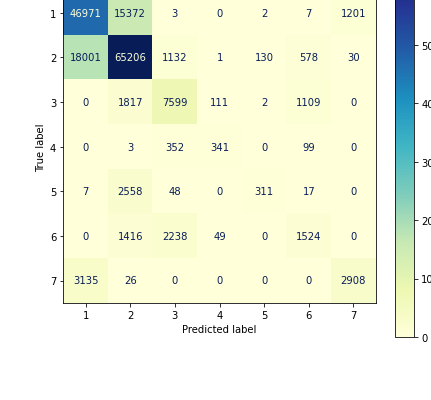

In [17]:
y_pred = net_classifier_1.predict(X_test_std)
matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(net_classifier_1, X_test_std, y_test, ax=ax, cmap='YlGnBu')
plt.title('Matriz de Confusão')
plt.show()

- A **acurácia** do modelo de classificação no conjunto de teste é de:

In [18]:
accuracy_score(y_test, y_pred)

0.716334679640169

- A seguir temos o valor da medida **F-score**, que também é:

In [19]:
f1_score(y_test, y_pred, average='macro')

0.5428292652204697

- A **precisão** tem valor:

In [15]:
precision_score(y_test, y_pred, average='macro')

0.6643405238842934

- Seguindo tem-se o valor da **Revocação** que assim como as outras é de:

In [16]:
recall_score(y_test, y_pred, average='macro')

0.5035996715363744

- A acurácia aparecem com valor mais alto em relação as outras métricas

### 8. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 100 vezes  
   

```
8.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
8.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino 
```

In [20]:
medidas = {'acuracias':[], 'fscores':[]}

for i in range(0, 2, 1):
    print('Treinando Rede Neural:', i, '...')

    # particionando o dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

    # escalonando os dados
    X_train_std = (X_train - X_train.mean()) / X_train.std()
    X_test_std = (X_test - X_train.mean()) / X_train.std()

    # treinando as redes neurais
    nnc = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', verbose=False, max_iter=300, shuffle=True)
    nnc.fit(X_train_std, y_train)

    # testando a rede neural treinada
    y_pred = nnc.predict(X_test_std)
    
    # salvando os valores das metricas
    medidas['acuracias'].append(accuracy_score(y_test, y_pred))
    medidas['fscores'].append(f1_score(y_test, y_pred, average='macro'))


Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...


- Média e desvio padrão das acurácias  referentes ao resultado dos testes das redes neurais treinadas anteriormente

In [21]:
np.mean(medidas['acuracias']), np.std(medidas['acuracias'])

(0.7172468790159721, 0.0005564989902698825)

- Média e desvio padrão dos F-scores referentes ao resultado dos testes das redes neurais treinadas anteriormente

In [22]:
np.mean(medidas['fscores']), np.std(medidas['fscores'])

(0.5120692071735202, 0.007340177607316589)

- Visualizando os valores das métricas 

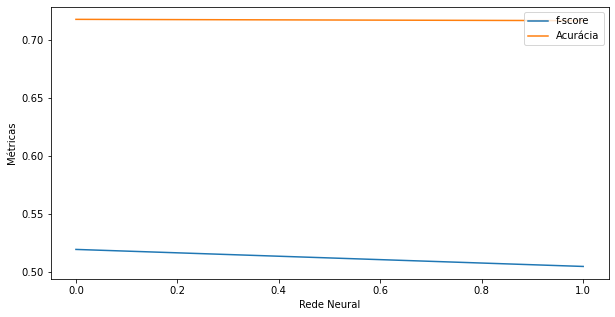

In [23]:
b = list(range(0, 2))
plt.figure(figsize=(10,5))
plt.plot(b, medidas['fscores'], label='f-score')
plt.plot(b, medidas['acuracias'], label="Acurácia")
plt.xlabel('Rede Neural')
plt.ylabel('Métricas')
plt.legend(loc='upper right');

### 9. Repita por 100 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  

```
9.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino 
``` 

In [24]:
medidas = {'acuracias':[], 'fscores':[]}

for i in range(0, 2, 1):
    print('Treinando Rede Neural:', i, '...')

    # particionando o dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

    # escalonando os dados
    X_train_std = (X_train - X_train.mean()) / X_train.std()
    X_test_std = (X_test - X_train.mean()) / X_train.std()

    # treinando as redes neurais
    nnc = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', verbose=False, max_iter=300, shuffle=True)
    nnc.fit(X_train_std, y_train)

    # testando a rede neural treinada
    y_pred = nnc.predict(X_test_std)
    
    # salvando os valores das metricas
    medidas['acuracias'].append(accuracy_score(y_test, y_pred))
    medidas['fscores'].append(f1_score(y_test, y_pred, average='macro'))


Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...


- Média e desvio padrão das acurácias  referentes ao resultado dos testes das redes neurais treinadas anteriormente

In [25]:
np.mean(medidas['acuracias']), np.std(medidas['acuracias'])

(0.7105516798237561, 0.00037864879750321156)

- Média e desvio padrão dos F-scores referentes ao resultado dos testes das redes neurais treinadas anteriormente

In [26]:
np.mean(medidas['fscores']), np.std(medidas['fscores'])

(0.46093839868776776, 0.022500107247431206)

- Visualizando os valores das métricas 

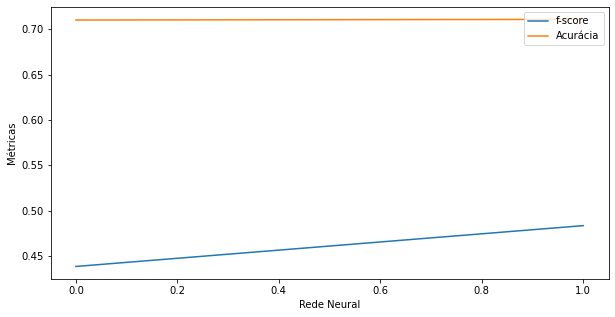

In [27]:
b = list(range(0, 2))
plt.figure(figsize=(10,5))
plt.plot(b, medidas['fscores'], label='f-score')
plt.plot(b, medidas['acuracias'], label="Acurácia")
plt.xlabel('Rede Neural')
plt.ylabel('Métricas')
plt.legend(loc='upper right');

#### 10. Houve influência da escolha do otimizador no desempenho da rede?

## Discussão

Nos passos anteriores, você avaliou o desempenho de uma única rede neural que contém os seguintes parâmetros: uma única camada oculta com 10 neurônios e função de ativação ReLU. O otimizador utilizado, quer seja SGD ou ADAM, trata-se do algoritmo para aproximar o gradiente do erro. Neste sentido, a escolha do otimizador é um hiperparâmetro, pois diz respeito a como a rede neural definida previamente atuará "em tempo de execução"  durante o processo de treinamento. Também são hiperparâmetros a quantidade de épocas, a taxa de aprendizado inicial, dentre outros.

Cabe alientar também que você efetuou o treinamento desta rede por 100 vezes e apresentou os resultados em termos de média +- desvio padrão. Lembre-se que em uma rede neural há a inicialização aleatória de pesos e, em consequência, o desempenho delas está sujeito à uma flutuação estocástica. A execução destas múltiplas vezes faz com que eliminemos algum viés introduzido por uma boa ou má "sorte" na escolha de pesos no caso de uma única execução.

Você também aprendeu uma estratégia para escalonar os atributos para uma melhor convergência da rede. Utilize-a em todos os treinamentos e testes propostos a seguir.

## Propondo Novas Arquiteturas

Variando  os parâmetros (uma ou duas camadas ocultas, com diferente números de neurônios em cada uma delas e a função de ativação) e o hiperparâmetros solver (Adam ou SGD) e o número de épocas (100,150 e 200), atenda ao que se pede:

1. Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha
2. Avalie cada uma das arquiteturas perante todos os hiperparâmetros apresentados por 100 vezes
3. Como resultado da avaliação, apresente:  
    3.1 Top-3 melhores redes no tocante à F-Score e Acurácia  
    3.2 Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn  

In [32]:
table = PrettyTable(["Camadas","Ativação", "Solver", "Épocas", "Neurônios", "Neurônios nas camadas"])        
table.padding_width = 1

parametros = {
    "hidden_layers": [(15,), (18,), (16, 17), (20, 30), (25, 35)],
    "solvers": ['adam', 'sgd'],
    "epochs": [100, 150, 200],
    "activation": ["identity", "logistic", "tanh", "relu"]
}

general_metrics_net = []

qtd_redes = 0
while qtd_redes < 3:
    medidas = {'acuracias':[], 'fscores':[]}

    for i in range(0, 2, 1):
        print('Treinando Rede Neural:', i, '...')

        # particionando o dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

        # escalonando os dados
        X_train_std = (X_train - X_train.mean()) / X_train.std()
        X_test_std = (X_test - X_train.mean()) / X_train.std()

        # treinando as redes neurais
        hid_la = parametros["hidden_layers"][random.randint(0, 4)]
        sol = parametros["solvers"][random.randint(0, 1)]
        ep = parametros["epochs"][random.randint(0, 2)]
        act = parametros["activation"][random.randint(0, 3)]
        
        table.add_row([len(hid_la), act, sol, ep, np.sum(hid_la), hid_la])


        nnc = MLPClassifier(hidden_layer_sizes=hid_la, activation=act, solver=sol, verbose=False, max_iter=ep, shuffle=True)
        nnc.fit(X_train_std, y_train)


        # testando a rede neural treinada
        y_pred = nnc.predict(X_test_std)
        
        # salvando os valores das metricas
        medidas['acuracias'].append(accuracy_score(y_test, y_pred))
        medidas['fscores'].append(f1_score(y_test, y_pred, average='macro'))

    general_metrics_net.append((np.mean(medidas['acuracias']), np.mean(medidas['fscores']), nnc))

    qtd_redes += 1

Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...
Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...
Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...
Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...
Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...
Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...
Treinando Rede Neural: 0 ...
Treinando Rede Neural: 1 ...


In [ ]:
print(table)

## Estimando o número de neurônios

Um dos problemas de pesquisa com redes neurais artificiais consiste na determinação do número de neurônios em sua arquitetura. Embora não seja possível definir a priori qual rede neural é adequada para um problema, pois isto só é possível mediante uma busca exaustiva, há regras na literatura que sugerem o número de neurônios escondidos, tal como a regra da Pirâmide Geométrica, dada a seguir:

$$N_h = \alpha \cdot \sqrt{N_i \cdot N_o},$$

em que $N_h$ é o número de neurônios ocultos (a serem distribuídos em uma ou duas camadas ocultas), $N_i$ é o número de neurônios na camada de entrada e $N_o$ é o número de neurônios na camada de saída. 

1. Consulte a documentação da classe MLPClassifier (disponível em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) e obtenha os valores de $N_i$ e $N_h$.
2. Teste os valores de $\alpha$ como sendo iguais a $0.5$, $2$ e $3$.
3. Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente  (solver, épocas, etc.)  
    3.1 Apresente as top-3 melhores redes no tocante à F-Score e Acurácia  

In [ ]:
import math
0.5 * math.sqrt(406708 * 7), 2 * math.sqrt(406708 * 7), 3 * math.sqrt(406708 * 7)

In [ ]:
table = PrettyTable(["Camadas","Ativação", "Solver", "Épocas", "Neurônios", "Neurônios nas camadas"])        
table.padding_width = 1

parametros = {
    "hidden_layers": [(843,), (3374,), (5061), (500, 343), (1000, 2374), (2000, 3061)],
    "solvers": ['adam', 'sgd'],
    "epochs": [100, 150, 200],
    "activation": ["identity", "logistic", "tanh", "relu"]
}

general_metrics_net_2 = []

qtd_redes = 0
while qtd_redes < 3:
    medidas = {'acuracias':[], 'fscores':[]}

    for i in range(0, 2, 1):
        print('Treinando Rede Neural:', i, '...')

        # particionando o dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

        # escalonando os dados
        X_train_std = (X_train - X_train.mean()) / X_train.std()
        X_test_std = (X_test - X_train.mean()) / X_train.std()

        # treinando as redes neurais
        hid_la = parametros["hidden_layers"][random.randint(0, 4)]
        sol = parametros["solvers"][random.randint(0, 1)]
        ep = parametros["epochs"][random.randint(0, 2)]
        act = parametros["activation"][random.randint(0, 3)]
        
        table.add_row([len(hid_la), act, sol, ep, np.sum(hid_la), hid_la])


        nnc = MLPClassifier(hidden_layer_sizes=hid_la, activation=act, solver=sol, verbose=False, max_iter=ep, shuffle=True)
        nnc.fit(X_train_std, y_train)


        # testando a rede neural treinada
        y_pred = nnc.predict(X_test_std)
        
        # salvando os valores das metricas
        medidas['acuracias'].append(accuracy_score(y_test, y_pred))
        medidas['fscores'].append(f1_score(y_test, y_pred, average='macro'))

    general_metrics_net_2.append((np.mean(medidas['acuracias']), np.mean(medidas['fscores']), nnc))

    qtd_redes += 1

In [ ]:
print(table)

## Testando as Redes Neurais com Atributos Categóricos

1. Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)
2. Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 100 repetições  
    2.1 Considere o melhor otimizador para cada uma delas  
    2.2 Faça uso de 200 épocas para treinamento  
    2.2 Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura
3. Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante as 100 repetições

In [ ]:
# pegando o top 6 pela melhor média de acurácia
general_metrics_net.sort(key=lambda x:x[0])
general_metrics_net_2.sort(key=lambda x:x[0])

a,b,c = general_metrics_net[0], general_metrics_net[1], general_metrics_net[2]
e,f,g = general_metrics_net_2[0], general_metrics_net_2[1], general_metrics_net_2[2]

In [ ]:
a[2]

## Considerações Parciais

1. É possível identificar uma rede com desempenho superior às demais?
2. Qual estratégia mostrou-se mais producente para a obtenção de boas arquiteturas (Estratégia Própria ou Pirâmide Geométrica)? Por quê?
3. Considerar os atributos categóricos trouxe melhorias? Justifique.
4. Um número maior de épocas trouxe melhorias?
5. Qual a maior dificuldade de resolução do problema proposto perante as RNAs?